In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn

# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
############## TENSORBOARD ########################
import sys
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/mnist1')
###################################################

In [4]:
# hyper parameters
input_size = 784 # 28 x 28
hidden_size = 100
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

# Data Loader and Transformation

In [5]:
# MNIST
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

8.3%

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw




100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [6]:
examples = iter(train_loader)
samples, labels = examples.next()
print(f'samples shape: {samples.shape}, labels shape: {labels.shape}')

samples shape: torch.Size([100, 1, 28, 28]), labels shape: torch.Size([100])


<function matplotlib.pyplot.show(close=None, block=None)>

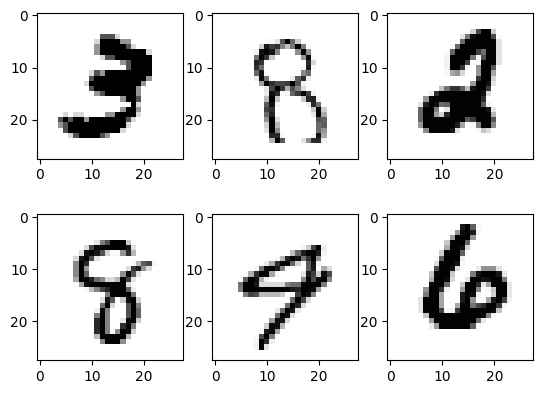

In [7]:
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.imshow(samples[i][0], cmap='Greys')
plt.show

In [8]:
############## TENSORBOARD ########################
img_grid = torchvision.utils.make_grid(samples)
writer.add_image('mnist_images', img_grid)
#writer.close()
#sys.exit()
###################################################

# Multilayer NN

In [9]:
class NeuralNet(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(NeuralNet, self).__init__()

    self.l1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.l2 = nn.Linear(hidden_size, num_classes)
  
  def forward(self, x):
    out = self.l1(x)
    out = self.relu(out)
    out = self.l2(out)
    return out

model = NeuralNet(input_size, hidden_size, num_classes)

In [10]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
############## TENSORBOARD ########################
writer.add_graph(model, samples.reshape(-1, 28*28))
#writer.close()
#sys.exit()
###################################################

In [19]:
# training loop
n_total_steps = len(train_loader)
running_loss = 0
running_correct_preds = 0
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.reshape(-1, 28*28).to(device)
    labels = labels.to(device)

    #forward
    outputs = model(images)
    loss = criterion(outputs, labels)
    #backwards
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    
    _, predictions = torch.max(outputs, 1)
    running_correct_preds += (predictions == labels).sum().item()
    if (i+1) % 100 == 0:
      print(f'epoch {epoch + 1} / {num_epochs}, step {i+1} / {n_total_steps}, loss {loss.item():4f}')
      writer.add_scalar('training loss', running_loss / 100, epoch * n_total_steps + i)
      writer.add_scalar('accuracy', running_correct_preds / 100, epoch * n_total_steps + i)
      running_loss = 0.0
      running_correct_preds = 0

epoch 1 / 2, step 100 / 600, loss 0.112420
epoch 1 / 2, step 200 / 600, loss 0.103714
epoch 1 / 2, step 300 / 600, loss 0.085994
epoch 1 / 2, step 400 / 600, loss 0.130033
epoch 1 / 2, step 500 / 600, loss 0.065460
epoch 1 / 2, step 600 / 600, loss 0.123872
epoch 2 / 2, step 100 / 600, loss 0.067153
epoch 2 / 2, step 200 / 600, loss 0.034333
epoch 2 / 2, step 300 / 600, loss 0.032351
epoch 2 / 2, step 400 / 600, loss 0.028324
epoch 2 / 2, step 500 / 600, loss 0.028717
epoch 2 / 2, step 600 / 600, loss 0.064125


In [17]:
# test
class_labels = []
class_preds = []
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  for images, labels in test_loader:
    images = images.reshape(-1, 28*28).to(device)
    labels = labels.to(device)
    outputs = model(images)

    # value, index
    _, predictions = torch.max(outputs, 1)
    n_samples += labels.shape[0]
    n_correct += (predictions == labels).sum().item()

    class_probs_batch = [F.softmax(output, dim=0) for output in outputs]
    class_preds.append(class_probs_batch)
    class_labels.append(predictions)
  
  # 10000, 10, and 10000, 1
  # stack concatenates tensors along a new dimension
  # cat concatenates tensors in the given dimension
  class_preds = torch.cat([torch.stack(batch) for batch in class_preds])
  class_labels = torch.cat(class_labels)

  acc = 100.0 * n_correct / n_samples
  print(acc)

96.73


In [18]:
############## TENSORBOARD ########################
classes = range(10)
for i in classes:
    labels_i = class_labels == i
    preds_i = class_preds[:, i]
    writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
    writer.close()
###################################################